In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py



In [14]:
# Test boundary value reductions. 

v_0, v_1 = set_bv(500, j.v_max, j.a_max)
assert v_0==j.v_max and v_1==j.v_max

v_0, v_1 = set_bv(250, j.v_max, j.a_max)
assert v_0==j.v_max and v_1==0

v_0, v_1 = set_bv(250, 2500, j.a_max)
assert v_0==2500 and round(v_1) == 4330

v_0, v_1 = set_bv(100, 2500, j.a_max)
assert v_0==2500 and round(v_1) == 1936

b = j.new_block(100,2500, 5_000).init()
assert b.v_0==2500 and round(b.v_1) == 1936

b = j.new_block(10,2500, 5_000).init()
b.v_0,b.v_1
assert b.v_0==1000 and b.v_1 == 0


<AxesSubplot:xlabel='x'>

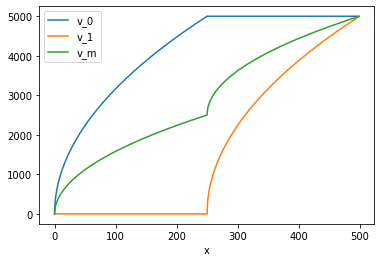

In [19]:
# Boundary Value reduction
j = Joint(5_000, 50_000)
rows = []
for x in range(500):
    v_0, v_1 = set_bv(x, v_max, a_max)
    rows.append(dict(x=x,v_0=v_0, v_1=v_1, v_m=(v_0+v_1)/2))

df = pd.DataFrame(rows)
df.set_index('x').plot()

In [20]:
# Test that values get passed through the Block sontructors. 
from trajectory.params import  Block, Joint

j = Joint(5_000, 50_000)
b = j.new_block(100,123,456)

assert b.x == 100, b.x
assert b.v_0 == 123
assert b.joint.v_max == 5_000

b = j.new_block(100,123,456)

assert b.x == 100
assert b.v_0 == 123
assert b.joint.v_max == 5_000


In [11]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert round(b.area) == b.x, (b, i, b.flag)
            if b.t != t:
                ot = b.t
                b.plan(ot)
                assert round(b.t, 6) == round(ot, 6), (b.t, t)
        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)        

100%|██████████| 11520/11520 [00:18<00:00, 636.81it/s]


In [3]:
i, tf, _ = errors[0]
i, (x, v_0, v_1) = limits()[i]
print(x, v_0, v_1)
b = j.new_block(x, v_0, v_1).init()
b.area, b.x

300 500 0


(299.49999999999994, 300)

In [5]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    try:
        b = j.new_block(x, v_0, v_1).init()
        t = b.t
    
        for tf in np.linspace(1.01, 3, num=10):
            b.plan(t * tf)
            b.plan_ramp(t)
    except:
        errors.append( (i,  (x, v_0, v_1), tf) )
        raise
        

 15%|█▌        | 1728/11520 [00:03<00:17, 560.92it/s]


ConvergenceError: Unsolvable profile: x=40, x_ad=2 t=0.12150463276836158 t_ad=0.01416

In [11]:
(i,  (x, v_0, v_1), tf) = errors[0]
print(i, x, v_0, v_1)
b = j.new_block(x, 0, 0).init()
print(b)
t = b.t

for tf in np.linspace(1.01, 3, num=10):
    print(t*tf)
    b.plan(t * tf)
    b.plan_ramp(t)

1728 40 0 0
Block(x=40, t=0.0565685424949238, t_a=0.0282842712474619, t_c=0.0, t_d=0.0282842712474619, x_a=20.0, x_c=0.0, x_d=20.0, v_0=0, v_c=1414.213562373095, v_1=0, d=1, joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='S', recalcs=0, next=None, prior=None)
0.05713422791987304
0.06964216120486175
0.08215009448985046
0.09465802777483916
0.10716596105982787
0.1196738943448166
0.1321818276298053
0.144689760914794
0.15719769419978272
0.16970562748477142
!!!! 38 39.1809798


ConvergenceError: Unsolvable profile: x=40, x_ad=2 t=0.16609860082304528 t_ad=0.00972

In [7]:
b = Block(x=10, t=0.034465021645021646, t_a=0.00462, t_c=0.021645021645021644, t_d=0.0082, x_a=1, x_c=5, 
          x_d=4, v_0=0, v_c=231, v_1=0, d=1, 
          joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='O', recalcs=0, next=None, prior=None)

print(consistantize(b),b.area)
b.plan(b.t)

5 6.06721962


Block(x=10, t=0.03146701298701299, t_a=0.00924, t_c=0.012987012987012988, t_d=0.00924, x_a=2, x_c=6, x_d=2, v_0=0, v_c=462, v_1=0, d=1, joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='T', recalcs=0, next=None, prior=None)

In [9]:
df.qc.value_counts(normalize=True)

O     0.949757
Z     0.050000
T0    0.000243
Name: qc, dtype: float64

In [ ]:
# Test resetting time, then 
# changing v_0 and v_1 and replanning. 

from tqdm import tqdm


j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in choices(limits(),k=1_000):
    b = j.new_block(x, v_0, v_1).init()
        
    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b.v_0 = randint(0,v_max)
            b.v_1 = randint(0,v_max)
            b.init()
            b.plan(b.t*tf)
            assert round(b.area) == b.x, (b, i, b.flag)

        except (Exception, AssertionError):
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  



In [ ]:
from copy import deepcopy

j = Joint(5_000, 50_000)

def make_segments():
    
    segments = []
    
    def _mkb(v_0, v_1):
        moves = [ (x, v_0, v_1) for i, (x, _, _) in choices(limits(),k=4) ]
        return [j.new_block(*args).init() for  args in moves]
    
    segments.append(_mkb(0, v_max))
    
    for i in range(2):
        segments.append(_mkb(v_max, v_max))
    
    segments.append(_mkb(v_max, 0))
    
    return segments

def plan_iter(blocks):
    
    sb = deepcopy(blocks) # save for later. 
    
    mt = max([ b.t for b in blocks])
    [b.plan(mt) for b in blocks]
    mt_new = max([ b.t for b in blocks])

    v_0_unchanged = all([ b1.v_0 == b2.v_0 for b1, b2 in zip(blocks, sb)])
    v_1_unchanged = all([ b1.v_1 == b2.v_1 for b1, b2 in zip(blocks, sb)])
    mt_unchanged = (mt_new == mt)
    
    a1 = [ round(b1.area) for b1 in blocks]
    a2 = [ round(b2.area) for b2 in sb]
    
    assert all([ a1 == a2 for a1, a2 in zip(a1, a2)])
    
    return  (v_0_unchanged and v_1_unchanged and mt_unchanged)
             
    
def plan_segment(blocks):    
    i = 0
    while True:
        if plan_iter(blocks):
            break
        i+=1
        assert i < 10
        
    return blocks
   

def forward_update_boundary(s1, s2):
    
    updates = 0
    for b1, b2 in zip(s1, s2):
        update = False
        if b1.v_1 != b2.v_0:
            v = min(b1.v_1, b2.v_0)
            b1.v_1 = v
            b2.v_0 = v
            updates +=1
            update = True
            

        #if abs(b1.v_c - b2.v_c) < 100:
        #    update = True
        #    b.v_0 = b.v_1 = (b1.v_c + b2.v_c)/2
            
            
        if update:
            b1.init()
            b2.init()
            
    return updates
    

#blocks = plan_segment()

#blocks = [ (b,) for b in blocks ]

segments = make_segments()


print([forward_update_boundary(s1, s2) for s1, s2 in zip(segments, segments[1:])])
[plan_segment(s) for s in segments]
print([forward_update_boundary(s1, s2) for s1, s2 in zip(segments, segments[1:])])
[plan_segment(s) for s in segments]


plot_params(*segments)


#print [ (b1.v_1, b2.v_0) for b1, b2 in zip(s1, s2[1:])]


AssertionError: (-1.0, 4995, 'S', Block(x=249, t=0.0997997997997998, t_a=0.0001, t_c=-0.0002002002002002002, t_d=0.0999, x_a=0.49975, x_c=-1.0, x_d=249.50025, v_0=5000, v_c=4995, v_1=0, v_0_max=None, v_0_min=0, v_1_max=None, v_1_min=0, t_min=0, d=1, joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='S', recalcs=0, jsclass=None, next=None, prior=None))

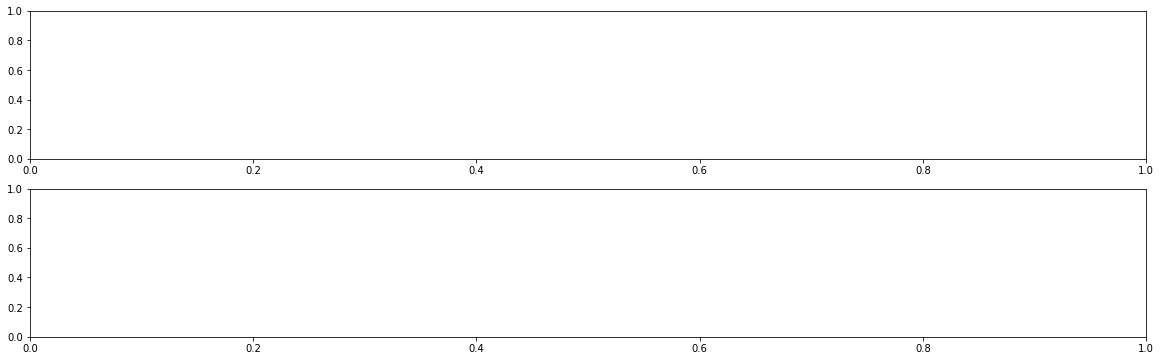

In [45]:
j = Joint(5_000, 50_000)

x = 249
v_0 = 5000
v_1 = 0

fig, ax = plt.subplots(2,1, figsize = (20, 6))
b = j.new_block(x, v_0, v_1).init()
end = .4
for t in np.linspace(b.t, end, num=4):
    b.plan_ramp(t)
    plot_params(b, ax=ax[0])

b = j.new_block(x, v_0, v_1).init()
for t in np.linspace(b.t, end, num=4):
    b.plan(t)
    plot_params(b, ax=ax[1])
    
    

In [ ]:
# Test simple updating between pairs of blocks

%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

step = 1_000
velocities = list(range(0, v_max+step, step))

vp = list(product(velocities, velocities))
keys = 'v_0 v_1'.split()

#v_args_a =  [dict(zip(keys, v)) for v in vp]
v_args_a =  [dict(v_0=v[0], v_1=v_max) for v in vp]
v_args_b =  v_args_a[-1:] + v_args_a[:-1]
v_args_c =  v_args_a[1:]  + v_args_a[:1]

records= []

def ip(args_a, args_b, args_c):
    return [min_profile(randint(10,2000),**args_a, v_max=v_max, a_max = a_max) for _ in range(3)]


for i,(args_a, args_b, args_c) in enumerate(zip(v_args_a, v_args_b, v_args_c)):
    records.append(ip(args_a, args_b, args_c))
   
def update_pair(p,n,t):
    ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

    v_0 = p.v_0
    v_1 = p.v_1
    p_t = p.t
     
    # Remake the profile
    # n = min_profile(*ag_mp(n.replace(v_0=p.v_1)))
    # expand the time
    
    n = update_params(n, max(t, n.t), v_0=p.v_1)
    
    for i in range(4):
        
        v_m = (p.v_1+n.v_0)/2
        p = min_profile(*ag_mp(p.replace(v_1=v_m)))
        n = min_profile(*ag_mp(n.replace(v_0=v_m)))

        n = update_params(n, max(t, n.t))
        p = update_params(p, p.t)
        
        if p.v_1 == n.v_0 and p.v_1 == v_m:
            break
        
    return i, p,n

counts = []
for i,r in enumerate(records):
    z, p,n = update_pair(r[0],r[1], r[1].t*1.5)
    counts.append(z)
    #plot_adj(p,n)

In [ ]:
from itertools import islice

def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk
        
for g in islice(grouper(3, all_p), 10):
    mt = max([p.t for p in g])
    if mt == 0:
        continue
    
    print(mt)
    


Updating 0
Updating 1
u plan
Updating 2
u plan
Updating 1
u plan


/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 0/1d@2468.23 -> 1/1a@0.0
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")


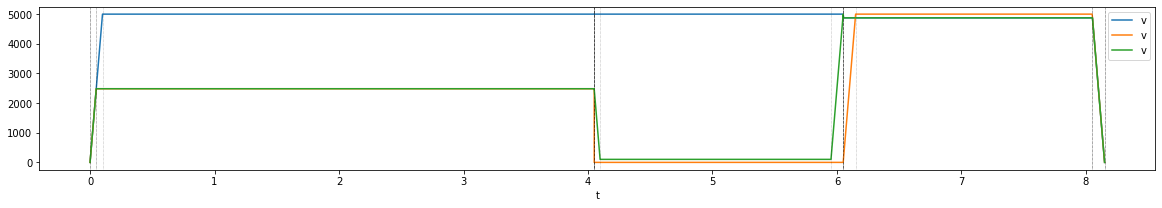

In [16]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import * 

j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([20000,10000,10000])
s = sl.rmove([10000,0,500])
s = sl.rmove([10000,10000,10000])

for i in range(len(sl)):
    sl.update_boundary(i)

for i in range(len(sl)):
    sl.plan(i)

for i in range(len(sl)):
    sl.update_boundary(i)

for i in range(len(sl)):
    sl.plan(i)
    
    
sl.plot()


/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 0/1d@2484.27 -> 1/1a@0.0
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 0/2d@2484.27 -> 1/2a@2468.23
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")
/Users/eric/Documents/proj/trajectory/trajectory/plot.py:32: UserWarning: Discontinuty 1/2d@224.61 -> 2/2a@5000.0
  warn(f"Discontinuty {a}@{last_row.v_f} -> {b}@{r.v_i}")


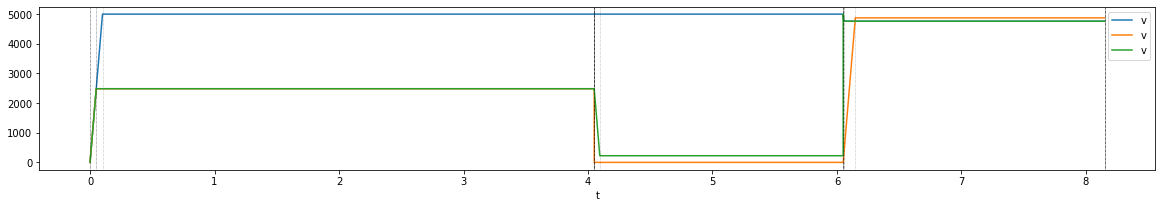

In [19]:
for s in sl:
    times = [j.b.t for j in s]
    mt = max(times)
    
    for j in s:
        j.b.plan_ramp(mt)

sl.plot()   

In [52]:
for s in sl:
    print([ j.b.t for j in s])

[0.30000000000000004, 0.30000000000000004, 0.30000000000000004]
[0.2, 0.2, 0.2]
[0.30000000000000004, 0.30000000000000004, 0.30000000000000004]


In [44]:
b = sl[0][2].b
b2 = sl[0][1].b
print(b.t, b2.t)
b.plan(b2.t)
b.t

0.25 0.30000000000000004


0.30000000000000004

In [35]:
sl.dataframe

,t,seg,axis,x,v_i,v_f,ss,del_t,v0m,v1m,calc_x,err
0,0.099961,0,0,250.0,0.00,4998.05,a,0.099961,None,None,249.804788,0.195212
1,0.249961,0,0,750.0,4998.05,4998.05,c,0.150000,None,None,749.707500,0.292500
2,0.250000,0,0,0.0,4998.05,5000.00,d,0.000039,None,None,0.195462,-0.195462
3,0.100000,0,1,250.0,0.00,5000.00,a,0.100000,None,None,250.000000,0.000000
4,0.200000,0,1,500.0,5000.00,5000.00,c,0.100000,None,None,500.000000,0.000000
5,0.300000,0,1,250.0,5000.00,0.00,d,0.100000,None,None,250.000000,0.000000
6,0.100000,0,2,250.0,0.00,5000.00,a,0.100000,None,None,250.000000,0.000000
7,0.250000,0,2,750.0,5000.00,5000.00,c,0.150000,None,None,750.000000,0.000000
8,0.250000,0,2,0.0,5000.00,5000.00,d,0.000000,None,None,0.000000,0.000000
9,0.250000,1,0,0.0,5000.00,5000.00,a,0.000000,None,None,0.000000,0.000000


In [ ]:
## Test joint windows
from trajectory.planner import * 

j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,0,500])
s = sl.rmove([1000,1000,1000])

p,c,n = sl.get_window(-1)

assert all([e is not None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is     None for e in n]) # Next is empty on last

p,c,n = sl.get_window(-2)

assert all([e is not None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is not None for e in n]) 

p,c,n = sl.get_window(-3)

assert all([e is     None for e in p]) 
assert all([e is not None for e in c]) 
assert all([e is not None for e in n]) 

p,c,n
plot_params(c, n)

In [ ]:
from operator import attrgetter
j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([1000,1000,1000])
s = sl.rmove([0,   500, 1000])
s = sl.rmove([1000,1000,1000])


def _f(index):

    p,c,n = sl.get_window(index)

    update_segment(p)
    update_segment(c)
    update_segment(n)

    min_idx = -1
    for e in zip(p,c,n):
        idx, u = update_boundary_velocities(*e)
        print(' ',u)
        min_idx = min(min_idx, idx)

        
    index += idx
    
    return index
ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_0_max v_1_max'.split())
index = _f(-1)
print(ag(sl[1][2].p), hex_area(*ag_ha(sl[1][2].p)))
index = _f(-1)
print(ag(sl[1][2].p), hex_area(*ag_ha(sl[1][2].p)))
sl.plot(); plt.show()

In [ ]:
index = -1
for i in range(5):
    index = _f(index)
    print (index)
    sl.plot(); plt.show()
    print(sl)
    if index == 0:
        break
    
    
display(sl.dataframe)

In [ ]:
# Test random segments, without segment-to-segment interactions


joints = [, Joint(5_000, 50_000), Joint(5_000, 50_000)]
sl = SegmentList(joints)   

inputs = []
for i in range(N):
    moves = [randint(-2000,2000) for _ in sl.joints] 

    limits = []
    for j in sl.joints:
        v_0_max = randint(0,j.v_max)
        v_0 = randint(0,j.v_max)
        v_1_max = randint(0,j.v_max)
        limits.append( (v_0_max, v_0 , v_1_max) )
        
    inputs.append( (moves, limits) )
      

In [ ]:
from trajectory.exceptions import ValidationError, ConvergenceError      
frames = []

def test_sl(moves, limits):
   
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    s = sl.rmove(moves)  
    
    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max
        
    s.update()
    
    sl.validate()
    
    return s


for i, (moves, limits) in enumerate(inputs):

    try:
        s = test_sl(moves, limits)
        
        v_0_in = [e[1] for e in limits]
        v_0_out = [js.v_0 for js in s]
        
        frames.append(s.params)
    except Exception as e:
        print('E ', type(e), i, e)

df = pd.concat(frames)
df[df.err_x > 1].sort_values('err_x', ascending=False)

In [ ]:
from trajectory.planner import max_v0_for_x

def run_segment(moves, limits, update=True):
    from trajectory.exceptions import ValidationError, ConvergenceError
    sl = SegmentList([Joint(5_000, 50_000), Joint(5_000, 50_000)])   
    
    s = sl.rmove(moves, update = update)  

    for js, (v_0_max, v_0, v_1_max) in zip(s,limits):
        js.v_0_max = v_0_max
        js.v_0 = v_0
        js.v_1_max = v_1_max   
    
    return sl


sl = run_segment([250,3000], [(5000, 5000, 0), (5000, 5000, 5000)], False)
sl.update()

plot_segment_list(sl.dataframe)
sl.dataframe

In [ ]:
sl = run_segment([500,3000], [(0, 0, 0), (5000, 5000, 0)])
sl.update()
plot_segment_list(sl.dataframe)
sl.dataframe


# Classification

In [ ]:
from collections import defaultdict
from random import shuffle
from trajectory.planner import classify, kind_icon_map

a_max= 50_000
v_max = 5_000


# Make new classification tests
dd = defaultdict(set)
for _ in range(10_000):
    x = max(randint(-500,1000), 0)
    v_0 = min(max(randint(-3000, v_max+2000), 0), v_max)
    v_1 = min(max(randint(-3000, v_max+2000), 0), v_max)
    args = (x, v_0, v_1, v_max, a_max)
    r = classify(*args)
    
    dd[r].add(args)

# Make the class_test list
l = []
for k, s in dd.items():
    s = list(s)
    shuffle(s)
    for v in s[:10]:
        l.append((v,k.name))
  
# Create a map from each classification to a set
# of values that has the (min, max) values for each parameter that produce that
# classification
min_max = {}
rows  = []
arg_names = 'x v_0 v_1 v_max, a_max'.split()
for k, s in dd.items():
    z = list(zip(*list(s)))
    z_min = [min(e) for e in z]
    z_max = [max(e) for e in z]
    
    min_max[k] =  list(zip(z_min, z_max))[:3]
    
    d = { 'name': k.name }
    for arg, mn, mx in list(zip(arg_names, z_min, z_max))[:3]:
        d[arg+'_min'] = mn
        d[arg+'_max'] = mx
    
    rows.append(d)
    
min_max_df = pd.DataFrame(rows)
min_max_df


In [ ]:
#  (x, v_0, v_1, v_max, a_max) 
class_test = [
 ((991, 3270, 2029, 5000, 50000), 'PENTAGON'),
 ((491, 4113, 5000, 5000, 50000), 'PENTAGON'),
 ((646, 3407, 4052, 5000, 50000), 'PENTAGON'),
 ((985, 1309, 4067, 5000, 50000), 'PENTAGON'),
 ((944, 4496, 1129, 5000, 50000), 'PENTAGON'),
 ((606, 2337, 2051, 5000, 50000), 'PENTAGON'),
 ((514, 1783, 2992, 5000, 50000), 'PENTAGON'),
 ((560, 3763, 556, 5000, 50000), 'PENTAGON'),
    
 ((4000, 0, 0, 5000, 50000), 'TRAPZEZOID'),
 ((546, 0, 0, 5000, 50000), 'TRAPZEZOID'),
    
 ((173, 3548, 3826, 5000, 50000), 'TROUGH'),
 ((188, 4335, 425, 5000, 50000), 'TROUGH'),
 ((30, 1732, 1732, 5000, 50000), 'TROUGH'),
 ((25, 1581, 1581, 5000, 50000), 'TROUGH'),
 ((7, 405, 836, 5000, 50000), 'TROUGH'),
 ((13, 765, 1140, 5000, 50000), 'TROUGH'),
 ((1, 316, 316, 5000, 50000), 'TROUGH'),
 ((10, 1000, 1000, 5000, 50000), 'TROUGH'),
    
 ((289, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((369, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((71, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((252, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((305, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((133, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((390, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((434, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((231, 0, 0, 5000, 50000), 'TRIANGLE'),
 ((281, 0, 0, 5000, 50000), 'TRIANGLE'),
    
 ((629, 0, 3151, 5000, 50000), 'ACEL'),
 ((918, 0, 4129, 5000, 50000), 'ACEL'),
 ((299, 0, 1317, 5000, 50000), 'ACEL'),
 ((576, 0, 570, 5000, 50000), 'ACEL'),
 ((784, 0, 2494, 5000, 50000), 'ACEL'),
 ((393, 0, 188, 5000, 50000), 'ACEL'),
 ((618, 0, 4152, 5000, 50000), 'ACEL'),
 ((862, 0, 1289, 5000, 50000), 'ACEL'),
 ((71, 0, 1392, 5000, 50000), 'ACEL'),
 ((123, 0, 3507, 5000, 50000), 'ACEL'),
    
 ((545, 441, 0, 5000, 50000), 'CLIFF'),
 ((987, 3106, 0, 5000, 50000), 'CLIFF'),
 ((836, 2502, 0, 5000, 50000), 'CLIFF'),
 ((418, 558, 0, 5000, 50000), 'CLIFF'),
 ((559, 904, 0, 5000, 50000), 'CLIFF'),
 ((202, 1662, 0, 5000, 50000), 'CLIFF'),
 ((270, 5000, 0, 5000, 50000), 'CLIFF'),
 ((257, 1856, 0, 5000, 50000), 'CLIFF'),
 ((381, 3522, 0, 5000, 50000), 'CLIFF'),
 ((869, 2426, 0, 5000, 50000), 'CLIFF'),
    
 ((115, 5000, 0, 5000, 50000), 'DECEL'),   
 ((25, 1785, 0, 5000, 50000), 'DECEL'),
 ((53, 5000, 0, 5000, 50000), 'DECEL'),
 ((35, 2898, 0, 5000, 50000), 'DECEL'),
 ((66, 4563, 0, 5000, 50000), 'DECEL'),
 ((100, 4458, 0, 5000, 50000), 'DECEL'),
 ((87, 5000, 0, 5000, 50000), 'DECEL'),
 ((42, 4511, 0, 5000, 50000), 'DECEL'),
    
 ((0, 0, 3438, 5000, 50000), 'ZERO'),
 ((0, 4255, 4443, 5000, 50000), 'ZERO'),
 ((0, 2960, 2762, 5000, 50000), 'ZERO'),
 ((0, 259, 116, 5000, 50000), 'ZERO'),
 ((0, 326, 1424, 5000, 50000), 'ZERO'),
 ((0, 3923, 0, 5000, 50000), 'ZERO'),
 ((0, 0, 3739, 5000, 50000), 'ZERO'),
 ((0, 4587, 1189, 5000, 50000), 'ZERO'),
 ((0, 2137, 5000, 5000, 50000), 'ZERO'),
 ((0, 2911, 0, 5000, 50000), 'ZERO')]

# These record produce a high x error when 
# recalculating the area
class_test_he = [
 ((193, 1018, 4588, 5000, 50000), 'TROUGH'), 
 ((233, 1029, 2812, 5000, 50000), 'TROUGH'), 
 ((218, 3779, 0, 5000, 50000), 'DECEL'),
 ((109, 2709, 0, 5000, 50000), 'DECEL')
]

In [ ]:
output = []
for args, name in class_test:
    assert classify(*args).name == name,  (classify(*args).name, name)
    output.append( (args,  classify(*args).name) )


In [ ]:
from trajectory.trapmath import *
    
rows = []
v_max = 5_000
a_max = 50_000
av = (v_max, a_max)

for _ in range(1_000):
    x = max(randint(-500,1000), 0)
    v_0 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    v_1 = min(max(randint(-3000, av[0]+2000), 0), av[0])
    
    args = (x, v_0, v_1, v_max, a_max)
    
    err = None
    try:
        p = min_time_parameters(x, v_0, v_1, v_max, a_max)
    except AssertionError as e:
        p = Params(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, InputParams(x, v_0, v_1, a_max, 0))
        err = f"{type(e)} {e}"
        print(args)
        raise
    except TrapMathError as e:
        p = Params(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, InputParams(x, v_0, v_1, a_max, 0))
        err = f"{type(e)} {e}"
        
    d = p.asdict()
    del d['ip']
    d['err'] = err
    rows.append(d)
    
mtp = pd.DataFrame(rows)
mtp.head()